<a href="https://colab.research.google.com/github/yukilost/googlecolab/blob/main/shoes_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルチタスク学習

## 初期設定

### ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import math
import random
import csv
import os
import pathlib
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive

### Google Driveのマウント

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


### 使用するデバイスの指定

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### 各種定数

In [4]:
img_path = "/content/drive/MyDrive/deep/data/"  # 画像が置かれているフォルダ
csv_path = "/content/drive/MyDrive/deep/collect.csv"  # csvファイル
csv_names = ["id", "url", "category", "brand", "price"]  # csvファイルの形式

## データセット

### スクレイピング

Google Colaboratoryでは動かないためローカルで実行する

In [ ]:
# import requests
# from selenium import webdriver
# from bs4 import BeautifulSoup
# import csv
# import time
# import re
# 
# # 画像を保存するディレクトリ
# imgdir = "./data/"
# 
# # 収集したデータの集合
# collected = set()
# 
# # 価格の最大値
# minprice = 10000000
# maxprice = 0
# 
# # カテゴリ、ブランドごとにデータを数える
# categories = {}
# brands = {}
# 
# # csvファイルから収集済みデータを読み込む
# file = open("collect.csv")
# reader = csv.reader(file)
# for row in reader:
#     collected.add(row[1])
#     categories.setdefault(row[2], 0)
#     categories[row[2]] += 1
#     brands.setdefault(row[3], 0)
#     brands[row[3]] += 1
#     if minprice > int(row[4]):
#         minprice = int(row[4])
#     if maxprice < int(row[4]):
#         maxprice = int(row[4])
# file.close()
# 
# # 書き込み用
# file = open("collect.csv", "a", encoding="utf-8", newline="")
# writer = csv.writer(file)
# 
# # 画像のファイル名に使用するid
# id = len(collected)
# 
# cat = ["sneakers", "slip-on", "sandal", "pumps", "boots", "dress-shoes", "ballet-slippers", "loafers", "moccasins", "rain-shoes"]
# start = 1
# end = 21
# 
# driver = webdriver.Chrome()
# soup = BeautifulSoup(driver.page_source, "html.parser")
# 
# for cate in cat:
#     for pagenum in range(start, end):
#         print("{} %".format((pagenum-start)/(end-start)*100))
#         url = "https://zozo.jp/category/shoes/"+cate+"/?pno=" + str(pagenum)
#         driver.get(url)
#         time.sleep(3)
#         soup = BeautifulSoup(driver.page_source, "html.parser")
#         items = soup.find_all("div", class_="catalog-item-container") 
#         for item in items:
#             discountrate = 0
# 
#             content = item.find("img", class_="catalog-img loader")
# 
#             # 稀にcontentがNoneTyepオブジェクトになるため
#             if content:
#                 imgref = content["data-src"]
#             else :
#                 content = item.find("img", class_="catalog-img")
#                 imgref = content["src"]
# 
#             # 収集済みであったらスキップ
#             if imgref in collected:
#                 continue
# 
#             # PR商品であったらスキップ
#             isPR = item.find("div", class_="feed-tag -pr")
#             if isPR != None:
#                 continue
# 
#             img = requests.get(imgref)
# 
#             # カテゴリ
#             # ナイキの「エアマックス（スニーカー）」のようになっているため正規表現によりカテゴリ部分のみを抽出する
#             category = re.match(".*（(.*?)）", content["alt"]).group(1)
# 
#             # 関係ないもの、扱いづらいものはスキップ
#             if category == "その他シューズ" or category == "シューケア用品" or category == "シューズアクセサリー" or category == "インソール/シューズクッション" or category == "シューズ小物/雑貨":
#                 continue
# 
#             # ブランド
#             brand = item.find("div", class_="catalog-h").text
# 
#             # 割引率
#             sale = item.find("span", class_="feed-tag -sale -discountrate")
#             if sale:
#                 discountrate = int(sale.text)
#             else :
#                 sale = item.find("span", class_="feed-tag -timesale -discountrate")
#                 if sale:
#                     discountrate = int(sale.text)
# 
#             # 値段
#             # ￥10,000 のように表示されているため記号を取り除き、割引き前の値段に修正
#             price = int(item.find("div", class_="catalog-price-amount").text[1:].replace(",", ""))
#             price = int(price * 100 / (100-discountrate))
# 
#             # 情報が欠けていたらスキップ
#             if not (imgref and category and brand and price and img):
#                 continue
# 
#             if minprice > price:
#                 minprice = price
#             if maxprice < price:
#                 maxprice = price
#             
#             categories.setdefault(category, 0)
#             categories[category] += 1
#             brands.setdefault(brand, 0)
#             brands[brand] += 1
# 
#             # 書き込み
#             writer.writerow([id, imgref, category, brand, price])
#             imgfile = open(imgdir + str(id) + ".jpg", "wb")
#             imgfile.write(img.content)
#             imgfile.close()
# 
#             # 商品に対して一意なimgrefをキーとして収集済みデータに登録する
#             collected.add(imgref)
# 
#             id += 1
# 
#             # 短時間に集中的にアクセスしないようにする
#             time.sleep(1)
# 
#         print("-"*40)
#         print("page {}".format(pagenum))
#         print("datanum : " + str(len(collected)) + "\n")
# 
#         print("category : " + str(len(categories)) + " categories")
#         for key in categories:
#             print(key + " : " + str(categories[key]))
#         print("\n")
# 
#         print("brand : " + str(len(brands)) + " brands")
#         for key in brands:
#             print(key + " : " + str(brands[key]))
#         print("\n")
# 
#         print("minprice : " + str(minprice))
#         print("maxprice : " + str(maxprice))
#         
#         time.sleep(10)
#     time.sleep(60)
# 
# driver.quit()
#     
# file.close()

### その他ブランドの追加

データ数が極端に少ないブランドを除外する

In [5]:
thresh = 150

df = pd.read_csv(csv_path, names=csv_names)
count = df["brand"].value_counts()

for i in range(len(df)):
  if count[df["brand"][i]] < thresh:
    df["brand"][i] = "その他"

count = df["brand"].value_counts()
print(count)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


その他                     13692
LibertyDoll               667
menue                     662
NIKE                      622
SESTO                     564
HUNTER                    454
AAA+                      436
Minnetonka                426
Odette e Odile            381
AmiAmi                    372
adidas                    350
Vivian                    328
New Balance               304
ORiental TRaffic          298
EMU Australia             270
Shoes in Closet           221
Fabio Rusconi             220
JELLY BEANS               217
EVOL                      202
RANDA                     193
MAMIAN                    193
SVEC                      190
KOBE LETTUCE              184
Dedes                     184
Dr.Martens                180
NOFALL                    179
Reebok                    177
PUMA                      177
FREAK’S STORE             173
SOROTTO                   170
green label relaxing      164
chumchum                  160
CONVERSE                  157
Name: bran

### ラベルの対応

In [6]:
label_to_category = np.sort(np.unique(df["category"]))
label_to_brand = np.sort(np.unique(df["brand"]))

data_num = len(df)
category_num = len(label_to_category)
brand_num = len(label_to_brand)

category_to_label = dict()
brand_to_label = dict()

for i in range(category_num):
  category_to_label[label_to_category[i]] = i
for i in range(brand_num):
  brand_to_label[label_to_brand[i]] = i

print(label_to_category)
print(category_to_label)
print(label_to_brand)
print(brand_to_label)

['サンダル' 'スニーカー' 'スリッポン' 'ドレスシューズ' 'バレエシューズ' 'パンプス' 'ブーツ' 'モカシン/デッキシューズ'
 'レインシューズ' 'ローファー']
{'サンダル': 0, 'スニーカー': 1, 'スリッポン': 2, 'ドレスシューズ': 3, 'バレエシューズ': 4, 'パンプス': 5, 'ブーツ': 6, 'モカシン/デッキシューズ': 7, 'レインシューズ': 8, 'ローファー': 9}
['AAA+' 'AmiAmi' 'CONVERSE' 'Dedes' 'Dr.Martens' 'EMU Australia' 'EVOL'
 'FREAK’S STORE' 'Fabio Rusconi' 'HUNTER' 'JELLY BEANS' 'KOBE LETTUCE'
 'LibertyDoll' 'MAMIAN' 'Minnetonka' 'NIKE' 'NOFALL' 'New Balance'
 'ORiental TRaffic' 'Odette e Odile' 'PUMA' 'RANDA' 'Reebok' 'SESTO'
 'SOROTTO' 'SVEC' 'Shoes in Closet' 'Vivian' 'adidas' 'chumchum'
 'green label relaxing' 'menue' 'その他']
{'AAA+': 0, 'AmiAmi': 1, 'CONVERSE': 2, 'Dedes': 3, 'Dr.Martens': 4, 'EMU Australia': 5, 'EVOL': 6, 'FREAK’S STORE': 7, 'Fabio Rusconi': 8, 'HUNTER': 9, 'JELLY BEANS': 10, 'KOBE LETTUCE': 11, 'LibertyDoll': 12, 'MAMIAN': 13, 'Minnetonka': 14, 'NIKE': 15, 'NOFALL': 16, 'New Balance': 17, 'ORiental TRaffic': 18, 'Odette e Odile': 19, 'PUMA': 20, 'RANDA': 21, 'Reebok': 22, 'SESTO': 23, 'SOROTTO'

### データの分析

data num : 23167

price
max : 209000
min : 550
average : 11039.710968187508
median : 7590.0

category num : 10
バレエシューズ         2400
ブーツ             2400
ドレスシューズ         2400
スリッポン           2399
ローファー           2394
サンダル            2386
レインシューズ         2383
パンプス            2375
スニーカー           2327
モカシン/デッキシューズ    1703
Name: category, dtype: int64

brand num : 33
その他                     13692
LibertyDoll               667
menue                     662
NIKE                      622
SESTO                     564
HUNTER                    454
AAA+                      436
Minnetonka                426
Odette e Odile            381
AmiAmi                    372
adidas                    350
Vivian                    328
New Balance               304
ORiental TRaffic          298
EMU Australia             270
Shoes in Closet           221
Fabio Rusconi             220
JELLY BEANS               217
EVOL                      202
RANDA                     193
MAMIAN                    193
SVEC

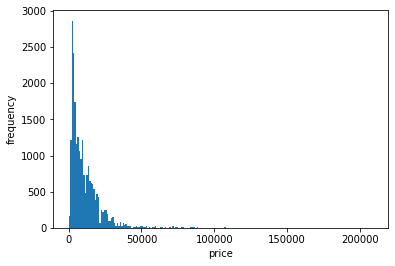

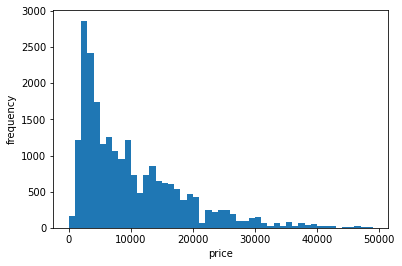

In [7]:
maxprice = np.max(df["price"])
minprice = np.min(df["price"])
aveprice = np.average(df["price"])
medprice = np.median(df["price"])

print("data num : {}\n".format(data_num))

print("price")
print("max : {}".format(maxprice))
print("min : {}".format(minprice))
print("average : {}".format(aveprice))
print("median : {}\n".format(medprice))

print("category num : {}".format(category_num))
print(df["category"].value_counts(), end='\n\n')

print("brand num : {}".format(brand_num))
print(df["brand"].value_counts())

plt.xlabel("price")
plt.ylabel("frequency")
plt.hist(df["price"],bins=np.arange(0, 210000, 1000))
plt.figure()
plt.xlabel("price")
plt.ylabel("frequency")
plt.hist(df["price"],bins=np.arange(0, 50000, 1000))
plt.show()

最高値データの確認

19018
209000
ローファー
その他


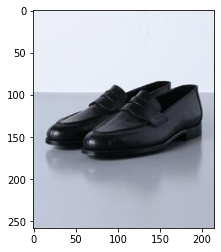

In [8]:
idx = np.argmax(df["price"])
print(df["id"][idx])
print(df["price"][idx])
print(df["category"][idx])
print(df["brand"][idx])
image = Image.open(img_path + str(idx) + ".jpg").convert('RGB')
plt.imshow(image)

### シャッフル

学習データとテストデータを固定するため

In [10]:
df_s = df.sample(frac=1, random_state=0).reset_index(drop=True)
print(df_s)

          id  ...  price
0        308  ...  13200
1      11476  ...  22000
2      14004  ...   3955
3       7765  ...   9900
4      13620  ...  32780
...      ...  ...    ...
23162  13123  ...  23100
23163  19648  ...  15400
23164   9845  ...  22000
23165  10799  ...  16484
23166   2732  ...   7587

[23167 rows x 5 columns]


### データセット作成

In [11]:
class Data(Dataset):
  def __init__(self, img_dir, img_transform, data):
    super().__init__() 

    self.img_dir = img_dir
    self.img_transform = img_transform

    self.size = len(data)
    self.id = data["id"]
    self.price = data["price"]
    self.category = data["category"]
    self.brand = data["brand"]

  def __len__(self):
    return self.size
  
  def __getitem__(self, idx):
    img = self.img_transform(Image.open(self.img_dir + str(self.id[idx]) + '.jpg').convert('RGB'))
    return img, self.price[idx], category_to_label[self.category[idx]], brand_to_label[self.brand[idx]]

img_transform = transforms.Compose([
  transforms.Resize([256, 256]),
  transforms.ToTensor()
])

train_size = 20002
train_batch_size = 73
test_size = data_num - train_size
test_batch_size = 211

df_train = df_s[:train_size]
print(df_train)

df_test = df_s[train_size:].reset_index(drop=True)
print(df_test)

train_dataset = Data(img_path, img_transform, df_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size)
test_dataset = Data(img_path, img_transform, df_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size)

          id  ...  price
0        308  ...  13200
1      11476  ...  22000
2      14004  ...   3955
3       7765  ...   9900
4      13620  ...  32780
...      ...  ...    ...
19997  22732  ...   2581
19998   6359  ...  13200
19999  13909  ...  18480
20000  22405  ...   7464
20001   8284  ...   7590

[20002 rows x 5 columns]
         id  ...  price
0     20054  ...   3289
1       391  ...   8250
2      3867  ...   3277
3     14606  ...   4950
4     18402  ...   1980
...     ...  ...    ...
3160  13123  ...  23100
3161  19648  ...  15400
3162   9845  ...  22000
3163  10799  ...  16484
3164   2732  ...   7587

[3165 rows x 5 columns]


train_datasetの確認

price : 13200
category : スニーカー
brand : NIKE



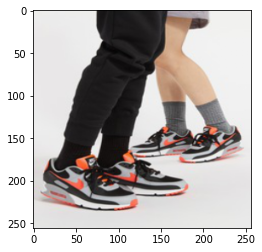

In [12]:
img, price, category_label, brand_label = train_dataset[0]
plt.imshow(np.asarray(img.numpy().copy().transpose(1, 2, 0)))
print("price : {}".format(price))
print("category : {}".format(label_to_category[category_label]))
print("brand : {}\n".format(label_to_brand[brand_label]))

test_datasetの確認

price : 3289
category : モカシン/デッキシューズ
brand : その他


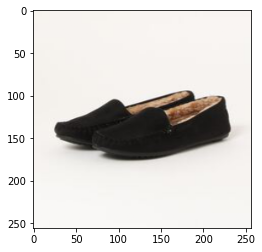

In [13]:
img, price, category_label, brand_label = test_dataset[0]
plt.figure()
plt.imshow(np.asarray(img.numpy().copy().transpose(1, 2, 0)))
print("price : {}".format(price))
print("category : {}".format(label_to_category[category_label]))
print("brand : {}".format(label_to_brand[brand_label]))

## ネットワーク

### ネットワーク定義

In [14]:
class MultiTaskModel(nn.Module):
  def __init__(self, category_size, brand_size):
    super().__init__()
  
    self.cnn = nn.Sequential(
        nn.Conv2d(3, 6, 5), nn.LeakyReLU(), nn.Conv2d(6, 12, 5), nn.LeakyReLU(), nn.MaxPool2d(4, 4),
        nn.Conv2d(12, 24, 5), nn.LeakyReLU(), nn.Conv2d(24, 48, 5), nn.LeakyReLU(), nn.MaxPool2d(3, 3),
        nn.Flatten()
    )
    
    self.price_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=1), nn.Identity()
    )
    
    self.category_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=category_size)
    )
    
    self.brand_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=brand_size)
    )
  
  def forward(self, x):
    x = self.cnn(x)
    price = self.price_fc(x).float()
    category = self.category_fc(x)
    brand = self.brand_fc(x)
    
    return price, category, brand

## 学習

### 損失関数

不均衡データのため頻度により重み付け

In [15]:
brand_freq = np.zeros(brand_num)

counts = df_train["brand"].value_counts()
for label in range(brand_num):
  brand_freq[label] = counts[label_to_brand[label]]

print(brand_freq)

weight = torch.Tensor(train_size / brand_freq).to(device)
print(weight)

[  374.   331.   135.   160.   154.   227.   175.   149.   191.   395.
   197.   169.   580.   168.   370.   535.   155.   265.   260.   335.
   155.   171.   148.   477.   154.   165.   191.   283.   297.   141.
   134.   562. 11799.]
tensor([ 53.4813,  60.4290, 148.1630, 125.0125, 129.8831,  88.1145, 114.2971,
        134.2416, 104.7225,  50.6380, 101.5330, 118.3550,  34.4862, 119.0595,
         54.0595,  37.3869, 129.0452,  75.4792,  76.9308,  59.7075, 129.0452,
        116.9708, 135.1487,  41.9329, 129.8831, 121.2242, 104.7225,  70.6784,
         67.3468, 141.8582, 149.2687,  35.5907,   1.6952], device='cuda:0')


RSMELossの定義

In [16]:
class RMSELoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x, y):
    mse = nn.MSELoss()
    eps = 1e-6
    return torch.sqrt(mse(x, y) + eps)

In [17]:
price_loss_function = RMSELoss()
category_loss_function = nn.CrossEntropyLoss()
brand_loss_function = nn.CrossEntropyLoss(weight=weight)

### モデルの学習

学習のログが記録されたcsvファイルとモデルの重みを読み込んで途中から再開  
パラメータを変えて最初から実行したい場合は```learn_csv_path```と```learn_params_path```を変更する。ファイルを作っておく必要はない。

In [18]:
# GPU利用制限に対応するため中断されたところから再開
learn_csv_path = "/content/drive/MyDrive/deep/learn_p1c1b1.csv"
learn_csv_names = ["running_train_losses", "running_train_price_losses", "running_train_category_accuracy", "running_train_brand_accuracy",
                   "running_test_losses", "running_test_price_losses", "running_test_category_accuracy", "running_test_brand_accuracy"]
learn_params_path = "/content/drive/MyDrive/deep/params/multi_p1c1b1.pth"

model = MultiTaskModel(category_num, brand_num).to(device)
optimizer = torch.optim.Adam(model.parameters())

if os.path.exists(learn_params_path):
  model.load_state_dict(torch.load(learn_params_path))
else :
  pathlib.Path(learn_params_path).touch()

if not os.path.exists(learn_csv_path):
  pathlib.Path(learn_csv_path).touch()

df = pd.read_csv(learn_csv_path, names=learn_csv_names)
finished_epoch = len(df)

epoch_num = 100
# 各lossが約1程度になるように正規化
lambda_price = 0.0001 * 1 # loss10000程度の値が出力されるため
lambda_category = 0.7 * 1
lambda_brand = 0.7 * 1

running_train_losses = df["running_train_losses"].values.tolist()
running_train_price_losses = df["running_train_price_losses"].values.tolist()
running_train_category_accuracy = df["running_train_category_accuracy"].values.tolist()
running_train_brand_accuracy = df["running_train_brand_accuracy"].values.tolist()

running_test_losses = df["running_test_losses"].values.tolist()
running_test_price_losses = df["running_test_price_losses"].values.tolist()
running_test_category_accuracy = df["running_test_category_accuracy"].values.tolist()
running_test_brand_accuracy = df["running_test_brand_accuracy"].values.tolist()

for epoch in range(epoch_num-finished_epoch):
  print("-"*50)
  print("epoch : {}/{}\n".format(epoch+finished_epoch+1, epoch_num))

  epoch_train_loss = 0
  epoch_train_price_loss = 0
  epoch_train_category_correct = 0
  epoch_train_brand_correct = 0

  epoch_test_loss = 0
  epoch_test_price_loss = 0
  epoch_test_category_correct = 0
  epoch_test_brand_correct = 0

  model.train()
  for count, (image, price, category_label, brand_label) in enumerate(train_loader):
    print("\rtrain batch : {}/{}".format(count+1, len(train_loader)), end='')
    optimizer.zero_grad()
    
    image = image.to(device)
    price = price.view(train_batch_size, 1).to(device).float()
    category_label = category_label.to(device)
    brand_label = brand_label.to(device)
  
    pred_price, pred_category, pred_brand = model(image)

    price_loss = price_loss_function(pred_price, price)
    category_loss = category_loss_function(pred_category, category_label)
    brand_loss = brand_loss_function(pred_brand, brand_label)
  
    loss = lambda_price*price_loss
    loss += lambda_category*category_loss
    loss += lambda_brand*brand_loss

    # print("loss : {}".format(loss.item()))
    # print("price_loss : {}".format(price_loss.item()))
  
    loss.backward()
    optimizer.step()

    epoch_train_loss += loss.item() 

    epoch_train_price_loss += price_loss.item()

    pred_category_label = np.argmax(pred_category.detach().cpu().numpy(), 1)
    epoch_train_category_correct += np.sum([pred_category_label == category_label.detach().cpu().numpy()])

    pred_brand_label = np.argmax(pred_brand.detach().cpu().numpy(), 1)
    epoch_train_brand_correct += np.sum([pred_brand_label == brand_label.detach().cpu().numpy()])

  # 1データあたりの損失に揃える
  running_train_losses.append(epoch_train_loss*train_batch_size/train_size)
  running_train_price_losses.append(epoch_train_price_loss*train_batch_size/train_size)
  running_train_category_accuracy.append(epoch_train_category_correct*100/train_size)
  running_train_brand_accuracy.append(epoch_train_brand_correct*100/train_size)

  model.eval()
  with torch.no_grad():
    for count, (image, price, category_label, brand_label) in enumerate(test_loader):
      print("\rtest batch : {}/{}".format(count+1, len(test_loader)), end='')

      image = image.to(device)
      price = price.view(test_batch_size, 1).to(device)
      category_label = category_label.to(device)
      brand_label = brand_label.to(device)
    
      pred_price, pred_category, pred_brand = model(image)
  
      price_loss = price_loss_function(pred_price, price)
      category_loss = category_loss_function(pred_category, category_label)
      brand_loss = brand_loss_function(pred_brand, brand_label)
    
      loss = lambda_price*price_loss
      loss += lambda_category*category_loss
      loss += lambda_brand*brand_loss

      epoch_test_loss += loss.item()

      epoch_test_price_loss += price_loss.item()

      pred_category_label = np.argmax(pred_category.detach().cpu().numpy(), 1)
      epoch_test_category_correct += np.sum([pred_category_label == category_label.detach().cpu().numpy()])
  
      pred_brand_label = np.argmax(pred_brand.detach().cpu().numpy(), 1)
      epoch_test_brand_correct += np.sum([pred_brand_label == brand_label.detach().cpu().numpy()])
    
  running_test_losses.append(epoch_test_loss*test_batch_size/test_size)
  running_test_price_losses.append(epoch_test_price_loss*test_batch_size/test_size)
  running_test_category_accuracy.append(epoch_test_category_correct*100/test_size)
  running_test_brand_accuracy.append(epoch_test_brand_correct*100/test_size)

  print("\ntrain")
  print("loss : {}".format(epoch_train_loss*train_batch_size/train_size))
  print("price loss : {}".format(epoch_train_price_loss*train_batch_size/train_size)) 
  print("category accuracy : {}".format(epoch_train_category_correct*100/train_size))
  print("brand accuracy : {}\n".format(epoch_train_brand_correct*100/train_size))

  print("test")
  print("loss : {}".format(epoch_test_loss*test_batch_size/test_size))
  print("price loss : {}".format(epoch_test_price_loss*test_batch_size/test_size)) 
  print("category accuracy : {}".format(epoch_test_category_correct*100/test_size))
  print("brand accuracy : {}\n".format(epoch_test_brand_correct*100/test_size))

  # 中断対策
  with open(learn_csv_path, 'a', encoding="utf-8", newline='') as f:
    writer = csv.writer(f)
    writer.writerow([running_train_losses[-1], running_train_price_losses[-1], running_train_category_accuracy[-1], running_train_brand_accuracy[-1],
                    running_test_losses[-1], running_test_price_losses[-1], running_test_category_accuracy[-1], running_test_brand_accuracy[-1]])

  torch.save(model.state_dict(), learn_params_path)
  

--------------------------------------------------
epoch : 1/100

test batch : 15/15
train
loss : 5.029282810044115
price loss : 13215.691976505474
category accuracy : 23.227677232276772
brand accuracy : 5.55944405559444

test
loss : 4.436105982462565
price loss : 11753.9416015625
category accuracy : 31.058451816745656
brand accuracy : 10.14218009478673

--------------------------------------------------
epoch : 2/100

test batch : 15/15
train
loss : 4.134213521532769
price loss : 10692.47131080349
category accuracy : 35.90640935906409
brand accuracy : 12.738726127387261

test
loss : 4.134605423609416
price loss : 11480.966536458332
category accuracy : 37.69352290679305
brand accuracy : 13.870458135860979

--------------------------------------------------
epoch : 3/100

test batch : 15/15
train
loss : 3.568749783682997
price loss : 10558.875406307026
category accuracy : 45.15548445155484
brand accuracy : 18.883111688831118

test
loss : 4.045751428604126
price loss : 11372.877311197917

## 評価

### 学習曲線

損失

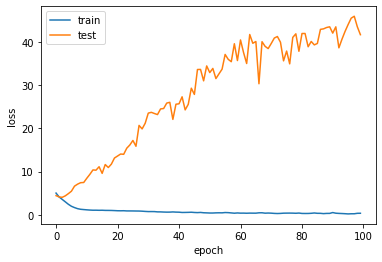

In [19]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('loss')
p1 = plt.plot(running_train_losses, label='train')
p2 = plt.plot(running_test_losses, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

値段のずれ

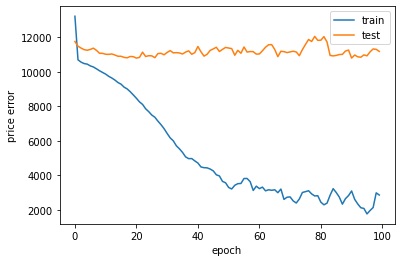

In [20]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('price error')
p1 = plt.plot(running_train_price_losses, label='train')
p2 = plt.plot(running_test_price_losses, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

micro平均

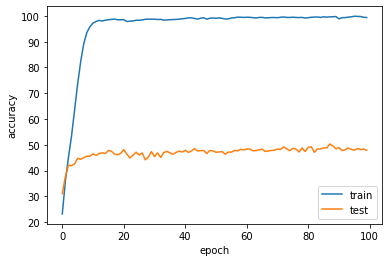

In [21]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('accuracy')
p1 = plt.plot(running_train_category_accuracy, label='train')
p2 = plt.plot(running_test_category_accuracy, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

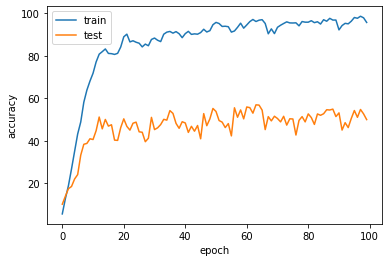

In [22]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('accuracy')
p1 = plt.plot(running_train_brand_accuracy, label='train')
p2 = plt.plot(running_test_brand_accuracy, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

### 具体例の確認

predicted price : 8617.4375, true price : 19800
predicted category : ブーツ, true category : スニーカー
predicted brand : その他, true brand : NIKE


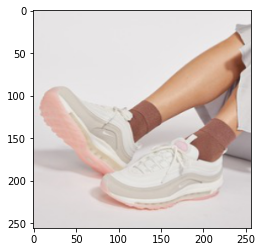

In [49]:
index = random.randint(0, test_size-1)
image, price, category_label, brand_label = test_dataset[index]
image = image.reshape(1, 3, 256, 256).to(device)

model.eval()
with torch.no_grad():
    pred_price, pred_category, pred_brand = model(image)

image = image.reshape(3, 256, 256)
image = image.cpu()
pred_category = pred_category.cpu()
pred_brand = pred_brand.cpu()

pred_category_label = np.argmax(pred_category.numpy().copy())
pred_brand_label = np.argmax(pred_brand.numpy().copy())

plt.imshow(np.asarray(image.numpy().copy().transpose(1, 2, 0)))

print("predicted price : {}, true price : {}".format(pred_price.item(), price))
print("predicted category : {}, true category : {}".format(label_to_category[pred_category_label], label_to_category[category_label]))
print("predicted brand : {}, true brand : {}".format(label_to_brand[pred_brand_label], label_to_brand[brand_label]))